# Benchmarking Data Normalization Methods with the Dexamethasone Benchmarking Resource (Limma Version)

This notebook reads in designated meta data and RNA-seq expression data files from a dexamethasone study and performs several different normalization methods - including counts per million (CPM), log transformation, and quantile normalization - on the data. 

Note: While it is generally advised to only use gene counts for limma, this notebook submits normalized gene counts to limma in order to examine whether that assertion is supported for each dataset. Additionally, z-score normalization cannot be performed here because the limma-voom program does not accept negative gene count values. 

After differential gene analysis and enrichment analysis, the results from each normalization method are compared with known transcription factor targets of dexamethasone and their downstream target genes. 

Some code has been adapted from the [Bulk RNA-seq Analysis Pipeline Appyter](https://appyters.maayanlab.cloud/Bulk_RNA_seq/).

In [75]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.display import display, Markdown
import json
import requests
import time
from random import sample
from itertools import zip_longest
from maayanlab_bioinformatics.dge import limma_voom
from maayanlab_bioinformatics.normalization import quantile, cpm, log, zscore
from maayanlab_bioinformatics.plotting.bridge import bridge_plot
import matplotlib.pyplot as plt

Note: You will need to install the `limma` and `edgeR` packages within R on your system in order to run this notebook successfully.

# Load in Data

Using data from GEO from the study ["Gene expression profiling of MDA_MB_231 cell line in response to treatment with Dexamethasone and SH4-54" (GSE137535)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE137535).

In [3]:
# Set all variables
meta_class_column_name = 'Class'
control_name = 'treatment: No Drug'
treatment = 'treatment: DEX'
meta_data_filename = 'GSE137535_series_matrix.txt'
rnaseq_data_filename = 'GSE137535_MB231_DEXwSH454TreamtentsFeatureCountsedited_SH454wDEX.counts.txt'
low_expression_threshold = 0.3

In [4]:
# Load in metadata
try:
    if meta_data_filename.endswith('.csv'): 
        meta_df = pd.read_csv(meta_data_filename, index_col=0)
    else:
        meta_df = pd.read_csv(meta_data_filename, sep="\t", index_col=0)
    print(f"Metadata file shape: {meta_df.shape[0]} samples, {meta_df.shape[1]} features")
except:
    print("Error! Please ensure the metadata file is in CSV, TXT, or TSV format.")

# Load in data
try:
    if rnaseq_data_filename.endswith('.csv'): 
        expr_df = pd.read_csv(rnaseq_data_filename, index_col=0).sort_index()
    else:
        expr_df = pd.read_csv(rnaseq_data_filename, sep="\t", index_col=0).sort_index()
    print(f"RNA-seq data file shape: {expr_df.shape[0]} genes, {expr_df.shape[1]} samples")
except:
    print("Error! Please ensure the RNA-seq file is in CSV, TXT, or TSV format.")

# Match samples between the metadata and the dataset
if meta_class_column_name not in meta_df.columns:
    print(f"Error! Column '{meta_class_column_name}' was not found in the metadata.")

shared_samples = set(meta_df.index).intersection(expr_df.columns)
meta_df = meta_df[meta_df.index.isin(shared_samples)].sort_values(by=['Class'])
expr_df = expr_df[shared_samples]
print(f"\nThe pipeline will be run on {len(shared_samples)} samples.")

Metadata file shape: 6 samples, 1 features
RNA-seq data file shape: 26364 genes, 12 samples

The pipeline will be run on 6 samples.


In [5]:
# Sort metadata by class labels; control first
expr_df = pd.concat([
    expr_df[meta_df[meta_df['Class']==control_name].index],
    expr_df[meta_df[meta_df['Class']!=control_name].index]
], axis=1)

In [6]:
## Filter out non-expressed genes
expr_df = expr_df.loc[expr_df.sum(axis=1) > 0, :]
## Filter out lowly expressed genes
mask_low_vals = (expr_df > low_expression_threshold).sum(axis=1) > 2
expr_df = expr_df.loc[mask_low_vals, :]
print(f"Number of genes after filtering by low expression: {expr_df.shape[0]}")

# Dictionary to store all normalized datasets
dataset = {'metadata': meta_df, 'rawdata': expr_df}

Number of genes after filtering by low expression: 17685


In [7]:
# Display meta data
dataset['metadata']

,Class
Sample_geo_accession,
GSM4081445,treatment: DEX
GSM4081446,treatment: DEX
GSM4081447,treatment: DEX
GSM4081451,treatment: No Drug
GSM4081452,treatment: No Drug
GSM4081453,treatment: No Drug


In [8]:
# Display expression data
dataset['rawdata']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,91,92,76,75,80,74
A1BG-AS1,13,10,12,16,21,19
A1CF,3,2,5,1,2,2
A2M-AS1,0,0,0,1,1,1
A2ML1,1,0,2,0,0,2
...,...,...,...,...,...,...
ZYG11A,496,488,429,352,434,327
ZYG11B,3118,2815,2728,2436,2897,2517
ZYX,773,666,579,633,621,582


# Normalization Methods

### CPM Normalization

In [10]:
# Perform CPM normalization
dataset['cpm'] = cpm.cpm_normalize(dataset['rawdata'])
dataset['cpm']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,2.884170,3.076275,2.672386,2.880211,2.718669,2.764710
A1BG-AS1,0.412024,0.334378,0.421956,0.614445,0.713651,0.709858
A1CF,0.095083,0.066876,0.175815,0.038403,0.067967,0.074722
A2M-AS1,0.000000,0.000000,0.000000,0.038403,0.033983,0.037361
A2ML1,0.031694,0.000000,0.070326,0.000000,0.000000,0.074722
...,...,...,...,...,...,...
ZYG11A,15.720313,16.317635,15.084914,13.517792,14.748782,12.217031
ZYG11B,98.822450,94.127340,95.924580,93.549264,98.449818,94.037510
ZYX,24.499600,22.269559,20.359359,24.308984,21.103672,21.744073


### Log Transformation

In [11]:
# Display log transformation results
dataset['log'] = log.log2_normalize(dataset['rawdata'])
dataset['log']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,6.523562,6.539159,6.266787,6.247928,6.339850,6.228819
A1BG-AS1,3.807355,3.459432,3.700440,4.087463,4.459432,4.321928
A1CF,2.000000,1.584963,2.584963,1.000000,1.584963,1.584963
A2M-AS1,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
A2ML1,1.000000,0.000000,1.584963,0.000000,0.000000,1.584963
...,...,...,...,...,...,...
ZYG11A,8.957102,8.933691,8.748193,8.463524,8.764872,8.357552
ZYG11B,11.606868,11.459432,11.414157,11.250891,11.500842,11.298063
ZYX,9.596190,9.381543,9.179909,9.308339,9.280771,9.187352


### Quantile Normalization

In [13]:
# Perform and display quantile normalization results
dataset['quantile'] = quantile.quantile_normalize(dataset['rawdata'])
dataset['quantile']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,77.909091,86.510417,76.180556,84.858974,81.541667,81.473684
A1BG-AS1,10.974910,9.359848,11.824324,18.295635,21.235632,21.184314
A1CF,2.367379,1.854730,4.832789,1.218622,2.123965,2.250130
A2M-AS1,0.000000,0.023035,0.056763,1.218622,1.056119,1.135578
A2ML1,0.795610,0.023035,1.930006,0.181692,0.063095,2.250130
...,...,...,...,...,...,...
ZYG11A,441.216667,468.357143,440.777778,387.222222,430.777778,351.791667
ZYG11B,2814.166667,2659.833333,2741.055556,2701.250000,2841.000000,2734.333333
ZYX,701.041667,641.833333,594.190476,697.361111,609.976190,617.777778


### Log Transform + Quantile Normalization

In [14]:
dataset['log+quantile'] = quantile.quantile_normalize(dataset['log'])
dataset['log+quantile']

,GSM4081451,GSM4081452,GSM4081453,GSM4081445,GSM4081446,GSM4081447
Geneid,,,,,,
A1BG,6.295506,6.445046,6.263684,6.417357,6.360852,6.359750
A1BG-AS1,3.574682,3.364984,3.672668,4.263593,4.468604,4.465174
A1CF,1.737439,1.491565,2.533610,1.127886,1.626342,1.685130
A2M-AS1,0.000000,0.023035,0.056763,1.127886,1.016936,1.073047
A2ML1,0.795610,0.023035,1.531735,0.181692,0.063095,1.685130
...,...,...,...,...,...,...
ZYG11A,8.785137,8.871426,8.783688,8.597002,8.751001,8.458842
ZYG11B,11.455165,11.373873,11.417403,11.396246,11.468898,11.413788
ZYX,9.452200,9.325327,9.214166,9.444582,9.251936,9.270319


In [23]:
# Store methods in a list
methods = [
    'rawdata', 'cpm', 'log', 'quantile', 'log+quantile'
]

# Comparing Methods
### Differential Gene Expression
Signatures for the original dataset and each of the normalized datasets are computed with the limma-voom method. The t-statistic is used for downstream analyses as a measure of differential expression.

In [45]:
# Function for computing signatures
def limma(control, treatment, dataset, normalization, meta_class_column_name):

    ctrl_ids = dataset["metadata"].loc[dataset["metadata"][meta_class_column_name] == control, :].index.tolist()  # control
    case_ids = dataset["metadata"].loc[dataset["metadata"][meta_class_column_name] == treatment, :].index.tolist()  # case

    # run limma
    signature = limma_voom.limma_voom_differential_expression(
        dataset[normalization].loc[:, ctrl_ids],
        dataset[normalization].loc[:, case_ids],
        filter_genes=True
    )
    signature = signature.sort_values("t", ascending=False)

    # return result
    return signature

In [46]:
# Get signatures
signatures = {}
for method in methods:
    signature = limma(control_name, treatment, dataset, method, meta_class_column_name)
    signatures[method] = signature

In [47]:
# Display signatures
for i in range(len(methods)):
    display(Markdown(f"{methods[i].capitalize()} dataset"))
    display(signatures[methods[i]])

Rawdata dataset

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SERPINE1,4.156452,8.698169,128.540022,1.689940e-17,2.338031e-13,29.410504
MT2A,2.472620,8.408159,75.615188,3.479818e-15,1.604776e-11,25.347162
MT1E,3.116105,7.924829,66.929956,1.183475e-14,4.093346e-11,24.244146
TSC22D3,3.664343,4.596304,60.806147,3.097820e-14,8.571669e-11,22.928492
FKBP5,2.607483,7.050542,57.596199,5.335390e-14,1.013390e-10,22.823395
...,...,...,...,...,...,...
TIMP3,-2.222582,6.789137,-46.733360,4.328170e-13,2.603488e-10,20.792354
SPNS2,-2.720799,3.429844,-47.184665,3.931230e-13,2.603488e-10,20.390060
SYNE1,-1.587130,7.021595,-47.526200,3.657431e-13,2.603488e-10,20.960417
PLAU,-1.794920,6.931556,-47.956893,3.341616e-13,2.603488e-10,21.048882


Cpm dataset

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SERPINE1,4.143833,8.701865,139.390592,2.935788e-19,2.781659e-15,33.778201
MT2A,2.462772,8.410984,80.567901,1.233895e-16,3.897052e-13,28.750930
MT1E,3.102647,7.929486,72.160861,4.152200e-16,9.835523e-13,27.605295
TSC22D3,3.568554,4.649500,66.064724,1.096981e-15,2.078778e-12,26.410101
NPR3,3.505657,4.804613,63.281165,1.761632e-15,2.781911e-12,26.021518
...,...,...,...,...,...,...
TIMP3,-2.216745,6.797412,-48.228095,3.490236e-14,1.322800e-11,23.207938
SPNS2,-2.592763,3.521401,-49.502591,2.620799e-14,1.117368e-11,23.276181
PLAU,-1.792920,6.938413,-50.915700,1.923718e-14,9.593277e-12,23.811645
SYNE1,-1.586947,7.027796,-52.653615,1.330343e-14,7.414704e-12,24.183923


Log dataset

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SERPINE1,0.432784,6.722918,127.763764,5.105800e-19,3.079308e-15,33.673551
MT1E,0.342053,6.646915,75.943451,1.682892e-16,3.383173e-13,28.511652
MT2A,0.262540,6.702435,73.671628,2.360263e-16,3.558686e-13,28.185274
FKBP5,0.305075,6.550466,69.904642,4.234389e-16,5.107520e-13,27.593884
TLR4,0.203690,6.593660,65.371318,8.932368e-16,8.978519e-13,26.873895
...,...,...,...,...,...,...
EVI2A,-0.232202,6.545277,-45.216595,5.381452e-14,1.475252e-11,22.727137
TIMP3,-0.265121,6.519796,-51.942088,1.153165e-14,3.863745e-12,24.312859
PLAU,-0.211081,6.539042,-53.763855,7.860666e-15,3.386263e-12,24.697568
SYNE1,-0.184988,6.550560,-54.397905,6.899932e-15,3.201038e-12,24.827774


Quantile dataset

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SERPINE1,4.090682,8.668887,127.655487,1.597547e-16,2.210525e-12,27.408780
MT2A,2.456691,8.400722,74.703887,2.425866e-14,1.118890e-10,23.528680
MT1E,3.089324,7.909015,72.378415,3.262384e-14,1.128540e-10,23.250294
TSC22D3,3.661833,4.600548,66.093356,7.639364e-14,2.114118e-10,21.967311
ANGPTL4,4.022360,4.170464,61.634990,1.469133e-13,3.388065e-10,21.276832
...,...,...,...,...,...,...
PLK2,-1.472095,8.286615,-47.336686,1.735743e-12,9.606990e-10,19.470736
PLAU,-1.785720,6.928456,-47.773141,1.593034e-12,9.583829e-10,19.555055
SPNS2,-2.695422,3.444132,-48.854272,1.292302e-12,8.701710e-10,19.246123
SYNE1,-1.580219,7.017874,-49.537513,1.134923e-12,8.265223e-10,19.890372


Log+quantile dataset

,logFC,AveExpr,t,P.Value,adj.P.Val,B
SERPINE1,0.424379,6.718991,144.167503,1.202811e-17,7.257759e-14,30.806824
MT2A,0.258663,6.700825,82.989658,2.698599e-15,4.602815e-12,25.886281
MT1E,0.338032,6.644193,81.955735,3.051253e-15,4.602815e-12,25.759848
TLR4,0.201979,6.592306,68.162544,1.854890e-14,1.981353e-11,23.964329
FKBP5,0.303988,6.549338,67.743996,1.970189e-14,1.981353e-11,23.905551
...,...,...,...,...,...,...
EVI2A,-0.232533,6.545455,-47.266931,6.660690e-13,1.913838e-10,20.296432
PLAU,-0.210414,6.539177,-53.730963,1.902690e-13,6.753430e-11,21.602776
PLK2,-0.156252,6.692472,-54.808968,1.566740e-13,6.642542e-11,21.752179
SYNE1,-0.184760,6.550532,-57.973660,9.047297e-14,4.962853e-11,22.363720


### Enrichment Analysis with Enrichr API
This section uses enrichr for enrichment analysis on the signatures to get rankings for NR3C1. Higher rankings (lower numbers) indicate a better method.

In [52]:
# Get gene lists to put into Enrichr
gene_lists = {'up': {}, 'down': {}, 'combined': {}}
for method in methods:
    gene_lists['up'][method] = signatures[method].head(250).index.tolist()
    gene_lists['down'][method] = signatures[method].tail(250).index.tolist()
    gene_lists['combined'][method] = gene_lists['up'][method] + gene_lists['down'][method]

In [40]:
# Function to get Enrichr Results
def Enrichr_API(enrichr_gene_list, library_name, method, direction):

    all_ranks = []
    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
    genes_str = '\n'.join(enrichr_gene_list)
    description = f'Dex benchmark {method} {direction} genes'
    payload = {
        'list': (None, genes_str),
        'description': (None, description)
    }

    response = requests.post(ENRICHR_URL, files=payload)
    if not response.ok:
        raise Exception('Error uploading gene list')

    list_data = json.loads(response.text)
    time.sleep(0.5)
    ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
    response = requests.get(
        ENRICHR_URL + f"?userListId={list_data['userListId']}&backgroundType={library_name}"
    )
    if not response.ok:
        raise Exception('Error fetching enrichment results')

    enrich_data = json.loads(response.text)
    results_df  = pd.DataFrame(enrich_data[library_name])
    all_ranks.append(list(results_df[0]))
    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    all_adjusted_pvalues.append(list(results_df[6]))

    res_dict = {
        'ranks': all_ranks, 
        'terms': all_terms, 
        'pvals': all_pvalues,
        'adjpvals': all_adjusted_pvalues, 
        'shortid': str(list_data['shortId'])
    }

    return res_dict

In [53]:
# Get results
results = {'up': {}, 'down': {}, 'combined': {}}
for direction in results.keys():
    for method in methods:
        results[direction][method] = Enrichr_API(
            gene_lists[direction][method], 'ChEA_2022', method, direction
        )

In [54]:
# Extract dexamethasone target rankings
# Initialize lists for storing target information
ranks = []
targets = ['NR3C1', 'NR0B1', 'NR1I2']

for method in methods: 
    for direction in results.keys():
        for i in range(len(results[direction][method]['ranks'][0])): 
            if any(t in results[direction][method]['terms'][0][i] for t in targets): 
                ranks.append([
                    f"{method}:{direction}",
                    results[direction][method]['terms'][0][i], 
                    results[direction][method]['ranks'][0][i],
                    results[direction][method]['pvals'][0][i]
                ])
full_df = pd.DataFrame(ranks, columns=['Gene_Set', 'Term', 'Rank', 'p-value'])
full_df['Method'] = full_df['Gene_Set'].apply(lambda x: x.split(':')[0])
full_df['Direction'] = full_df['Gene_Set'].apply(lambda x : x.split(':')[1])
full_df['TF'] = full_df['Term'].apply(lambda x: x.split(' ')[0])

In [55]:
up_df = full_df[full_df['Direction']=='up']
down_df = full_df[full_df['Direction']=='down']
combined_df = full_df[full_df['Direction']=='combined']

### Comparing Rankings

Below are tables and graphs with a summary of the rankings results. For each method, the rankings are averaged across the different dexamethasone target terms.

In [56]:
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method."))
display(up_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method."))
display(down_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))
display(Markdown("Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method."))
display(combined_df.groupby(['Method']).mean().sort_values(['Rank', 'Method']).drop(['p-value'], axis=1))

Mean ranks of Dex target gene terms from ChEA 2022 for up genes from each method.

,Rank
Method,
log,84.285714
log+quantile,94.428571
cpm,99.000000
quantile,102.857143
rawdata,106.285714


Mean ranks of Dex target gene terms from ChEA 2022 for down genes from each method.

,Rank
Method,
rawdata,339.250
quantile,345.625
cpm,349.125
log,350.875
log+quantile,351.625


Mean ranks of Dex target gene terms from ChEA 2022 for combined up and down genes from each method.

,Rank
Method,
log,202.625
rawdata,210.375
quantile,212.625
log+quantile,213.375
cpm,217.750


We can also examine the average rankings for each dexamethasone target individually.

In [57]:
# Calculate and sort by mean rank grouping by method and name

up_df_averages_byTF = up_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method"))
display(up_df_averages_byTF)

down_df_averages_byTF = down_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method"))
display(down_df_averages_byTF)

combined_df_averages_byTF = combined_df.groupby(['TF', 'Method']).mean().sort_values(['TF', 'Rank']).drop(['p-value'], axis=1)
display(Markdown("Mean rankings for each Dex target TF, based on enrichment analysis of combined up and down genes from each method"))
display(combined_df_averages_byTF)

Mean rankings for each Dex target TF, based on enrichment analysis of up genes from each method

Rank
TF    Method             
NR0B1 log           219.0
      log+quantile  244.0
      cpm           381.0
      rawdata       474.0
      quantile      475.0
NR1I2 quantile      102.0
      rawdata       104.0
      cpm           126.0
      log           197.0
      log+quantile  233.0
NR3C1 quantile       28.6
      rawdata        33.2
      log            34.8
      log+quantile   36.8
      cpm            37.2

Mean rankings for each Dex target TF, based on enrichment analysis of down genes from each method

Rank
TF    Method                  
NR0B1 log+quantile  274.000000
      rawdata       282.000000
      quantile      304.000000
      cpm           310.000000
      log           321.000000
NR1I2 log+quantile  309.000000
      log           330.000000
      cpm           412.000000
      rawdata       493.000000
      quantile      524.000000
NR3C1 quantile      322.833333
      rawdata       323.166667
      cpm           345.166667
      log           359.333333
      log+quantile  371.666667

Mean rankings for each Dex target TF, based on enrichment analysis of combined up and down genes from each method

Rank
TF    Method                  
NR0B1 log+quantile  254.000000
      log           267.000000
      cpm           351.000000
      rawdata       374.000000
      quantile      392.000000
NR1I2 cpm           241.000000
      rawdata       254.000000
      log           256.000000
      log+quantile  268.000000
      quantile      268.000000
NR3C1 quantile      173.500000
      rawdata       175.833333
      log           183.000000
      cpm           191.666667
      log+quantile  197.500000

In [58]:
color_dict = {
    'rawdata': 'crimson',
    'random': 'black',
    'log': '#636EFA',
    'quantile': '#636EFA',
    'cpm': '#636EFA',
    'z': '#636EFA',
    'log+quantile+z': '#636EFA', 
    'log+quantile': '#636EFA'
}

## Random results

As a sanity check, we can bootstrap random results and compare against the results for each of the methods, as even in the case of raw data we would expect to see some prioritization of dexamethasone target genes if the data is correct. 

We can achieve this by randomly sampling 250 and 500 genes, respectively, from all genes in the dataset multiple times, and then performing the same process of ranking the enrichment analysis results for the random gene sets. 

In [60]:
# bootstrap random results
random_arr = []
for i in range(10):
    rand_250 = sample(dataset['rawdata'].index.tolist(), 250)
    rand_500 = sample(dataset['rawdata'].index.tolist(), 500)
    random_arr.append(('random:250', Enrichr_API(rand_250, 'ChEA_2022', 'random', '250')))
    random_arr.append(('random:500', Enrichr_API(rand_500, 'ChEA_2022', 'random', '500')))

rand_ranks = [] 
for res in random_arr: 
    for i in range(len(res[1]['ranks'][0])):
        if any(t in res[1]['terms'][0][i] for t in targets): 
            rand_ranks.append([
                f"{res[0]}", 
                res[1]['terms'][0][i],
                res[1]['ranks'][0][i],
            ])
rand_df = pd.DataFrame(rand_ranks, columns=['Gene_Set', 'Term', 'Rank'])
rand_df['Method'] = 'random'
rand_df['TF'] = rand_df['Term'].apply(lambda x: x.split(' ')[0])

## Boxplots

Using boxplots, we can visualize the average rankings of the dexamethasone target terms that are displayed in the tables above. This provides a clearer sense of which methods appear to be performing better (smaller numerical rank) across all the terms.

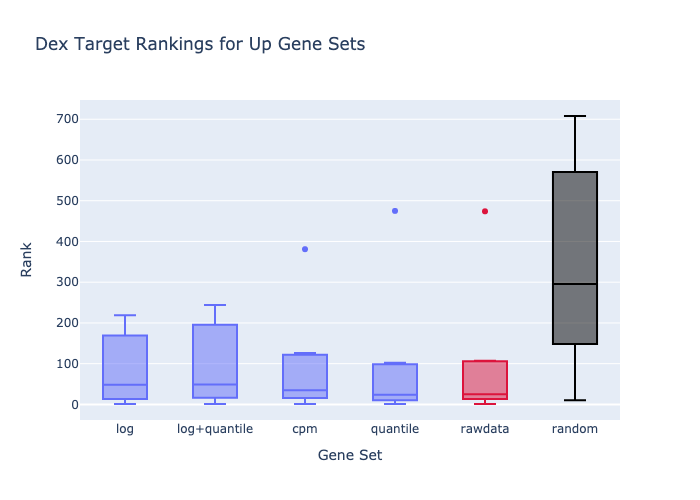

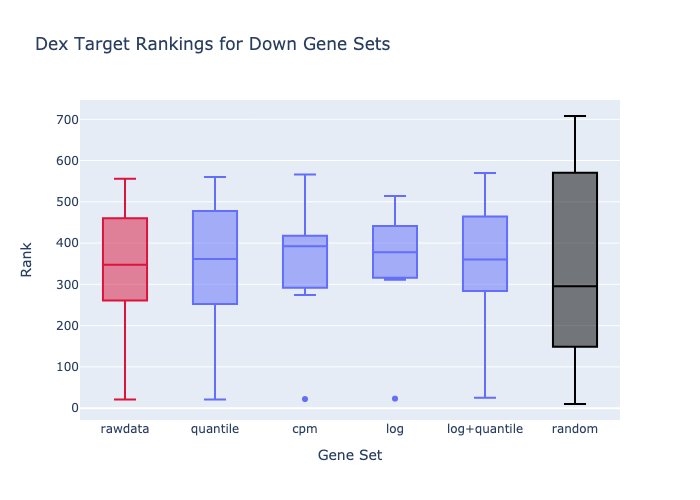

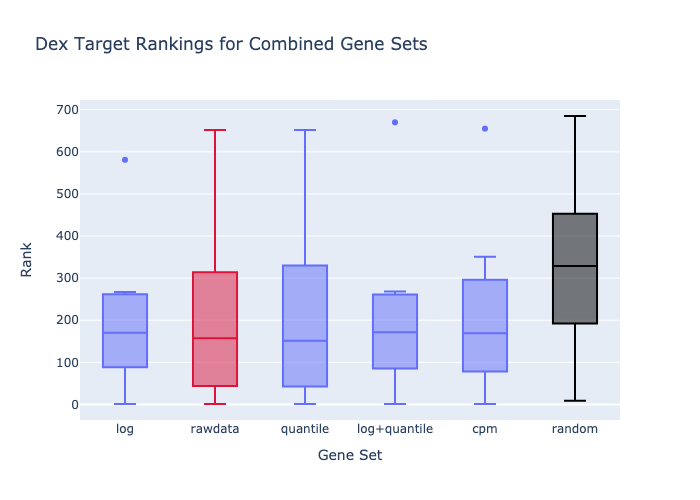

In [62]:
for d in full_df['Direction'].unique(): 
    sub_df = full_df[full_df['Direction']==d]
    if d == 'combined':
        n = '500'
    else:
        n = '250'

    fig1 = go.Figure()
    for gs in sub_df.groupby('Gene_Set').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Gene_Set']==gs]['Rank'].tolist(),
                name=gs.split(':')[0], 
                marker_color=color_dict[gs.split(':')[0]]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']==f'random:{n}']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Dex Target Rankings for {d.capitalize()} Gene Sets",
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

Again, we can break down the results by each target, displaying the rankings of the up/down/combined gene sets for each method corresponding to each target.

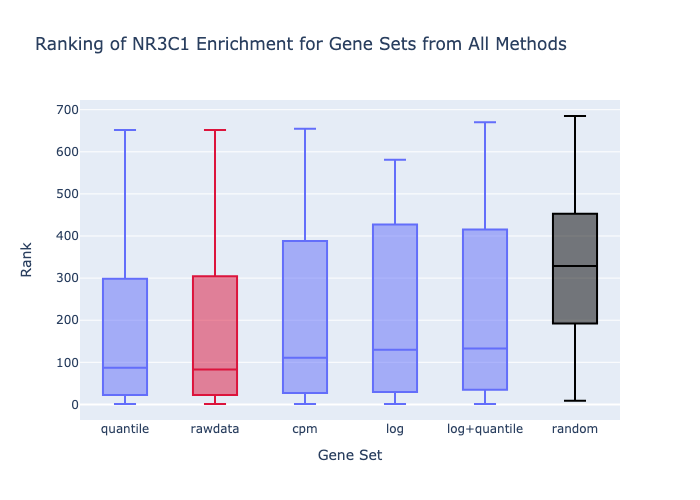

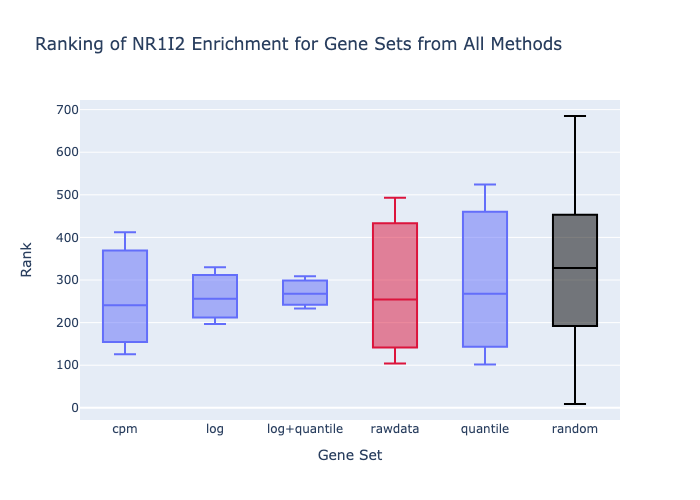

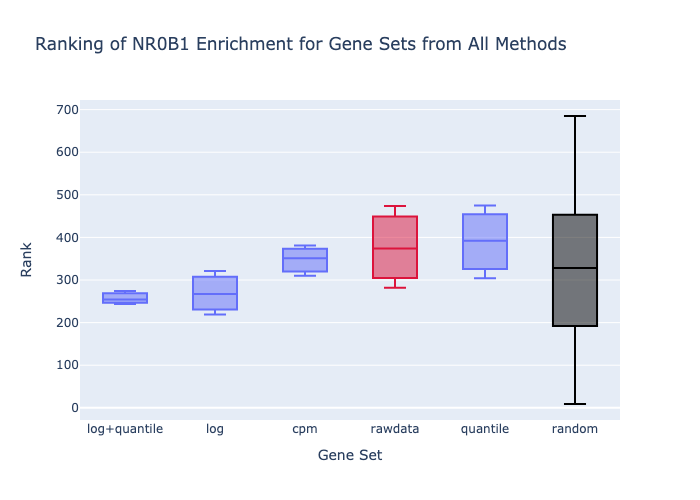

In [63]:
for tf in full_df['TF'].unique(): 
    fig1 = go.Figure()
    sub_df = full_df[full_df['TF'] == tf]
    for m in sub_df.groupby('Method').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Method']==m]['Rank'].tolist(),
                name=m, 
                marker_color=color_dict[m]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of {tf} Enrichment for Gene Sets from All Methods",
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

For a more granular view, we can separate out the up, down and combined gene sets for each transcription factor, which allows us to see patterns across method and direction for each target.

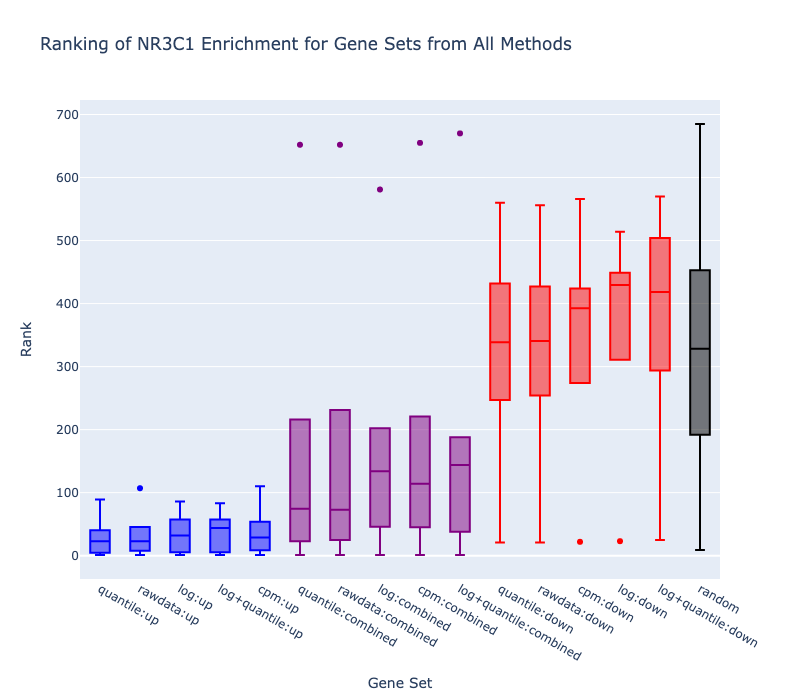

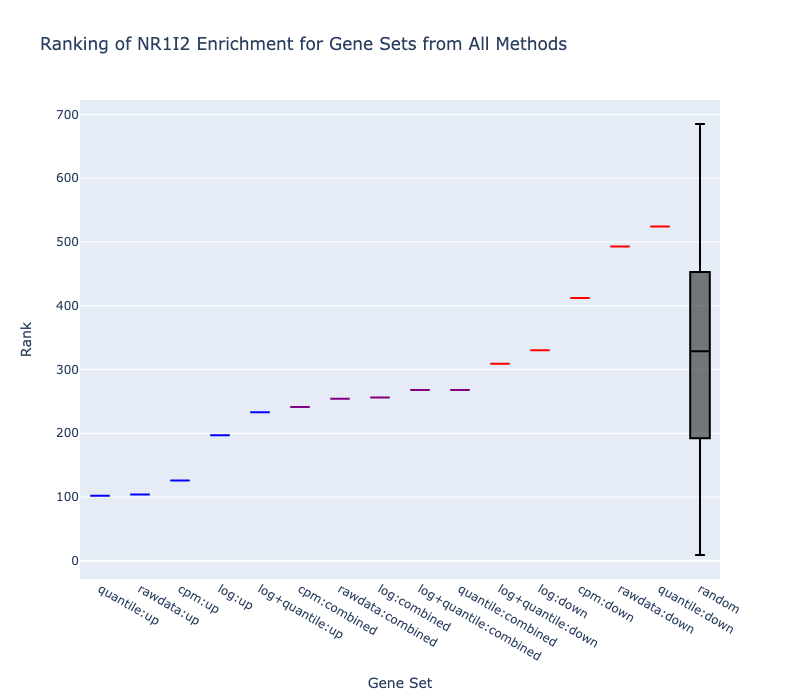

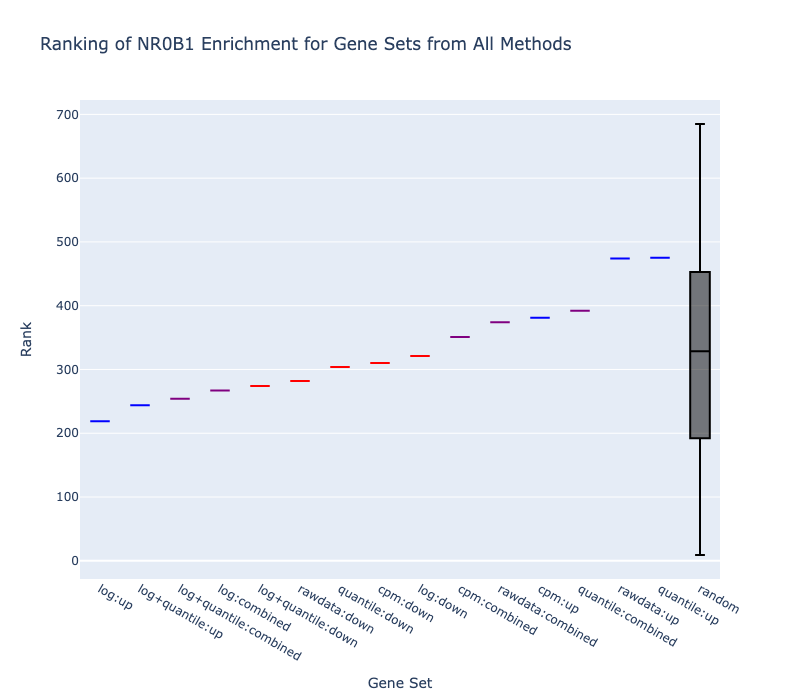

In [64]:
dir_color_map = {
    'up': 'blue', 
    'down': 'red',
    'combined': 'purple'
}

for tf in full_df['TF'].unique(): 
    fig1 = go.Figure()
    sub_df = full_df[full_df['TF'] == tf]
    for gs in sub_df.groupby('Gene_Set').mean().sort_values('Rank').index:
        fig1.add_trace(
            go.Box(
                y=sub_df[sub_df['Gene_Set']==gs]['Rank'].tolist(),
                name=gs, 
                marker_color=dir_color_map[gs.split(':')[1]]
            )
        )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of {tf} Enrichment for Gene Sets from All Methods",
        width=800,
        height=700,
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

In [88]:
def fullBoxplot(color_by_dir=True):
    fig1 = go.Figure()
    for gs in full_df.groupby('Gene_Set').median().sort_values('Rank').index:
        if color_by_dir:
            fig1.add_trace(
                go.Box(
                    y=full_df[full_df['Gene_Set']==gs]['Rank'].tolist(),
                    name=gs, 
                    marker_color=dir_color_map[gs.split(':')[1]]
                )
            )
        else:
            fig1.add_trace(
                go.Box(
                    y=full_df[full_df['Gene_Set']==gs]['Rank'].tolist(),
                    name=gs, 
                    marker_color=color_dict[gs.split(':')[0]]
                )
            )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:250']['Rank'].tolist(),
            name='random:250',
            marker_color='black'
        )
    )
    fig1.add_trace(
        go.Box(
            y=rand_df[rand_df['Gene_Set']=='random:500']['Rank'].tolist(),
            name='random:500',
            marker_color='black'
        )
    )

    fig1.update_layout(
        title_text=f"Ranking of Dex Target Enrichment for All Method Gene Sets",
        width=800,
        height=700,
        xaxis={
            'title': {'text': 'Gene Set'}, 
        },
        yaxis={
            'title': {'text': 'Rank'}
        },
        showlegend=False
    )
    fig1.show("png")

Finally, we can look at the average across all transcription factors for each method and direction. The two plots below are colored by the direction of the gene set (up, down or combined) and by the method, respectively.

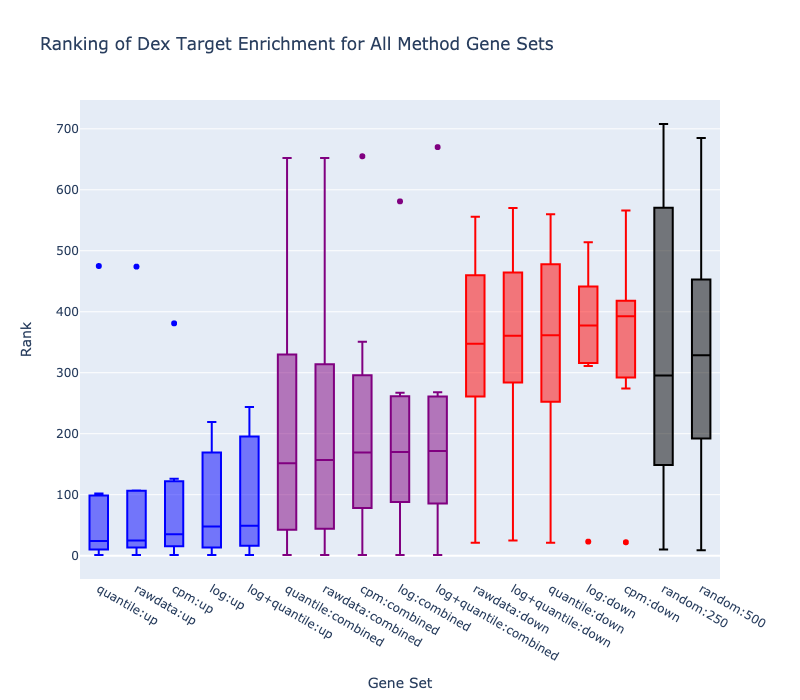

In [89]:
fullBoxplot()

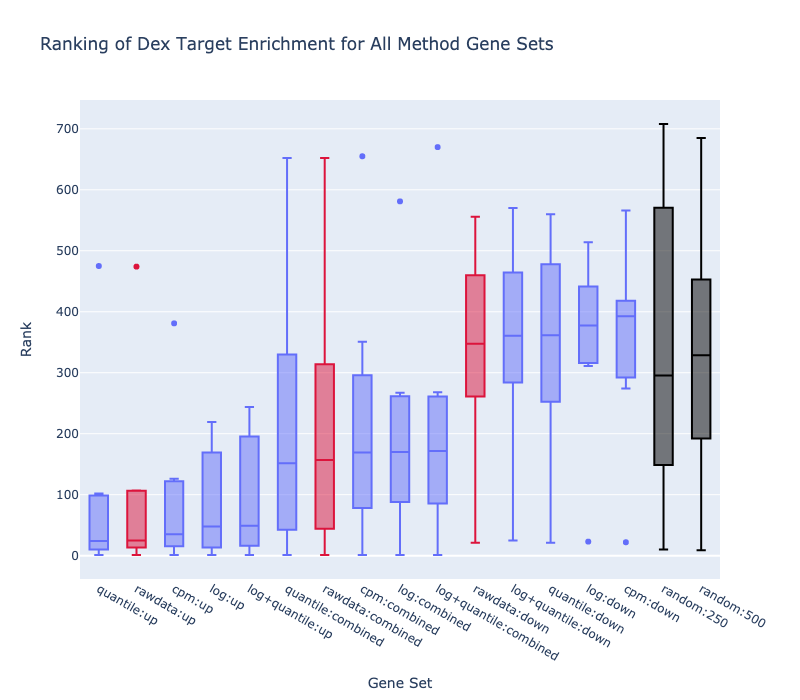

In [90]:
fullBoxplot(color_by_dir=False)

## Bridge plots

The below plots provide the Brownian bridge plots comparing the ranked genes from each method signature with the genes in the target TF gene sets.

In [65]:
def getEnrichrGeneSets(libname, termlist): 
    term_dict = {}
    liburl = f'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName={libname}'
    response = requests.get(liburl)
    if not response.ok:
        raise Exception('Error fetching library from Enrichr')
    for term in termlist:
        geneset = response.json()[libname]['terms'][term].keys()
        term_dict[term] = geneset
    return term_dict

target_genesets = getEnrichrGeneSets('ChEA_2022', full_df['Term'].unique())

In [72]:
def singleBridgePlot(gsname, signame, abs_t=False):
    geneset = target_genesets[gsname]

    if abs_t == True:
        abs_vals = signatures[signame]['t'].apply(abs).sort_values(ascending=False)
        select = pd.Series(
            [x.upper() in geneset for x in abs_vals.index.tolist()]
        )
    else:
        select = pd.Series(
            [x.upper() in geneset for x in signatures[signame].index.tolist()]
        )
    x, y = bridge_plot(select)
    x = x/len(x)
    return x,y

def randomBridgePlot(gsname): 
    all_x = []
    all_y = []

    for _ in range(10):
        rand_sig = sample(
            signatures['rawdata'].index.tolist(), 
            signatures['rawdata'].shape[0]
        )
        select = pd.Series([
            x.upper() in target_genesets[gsname] for x in rand_sig
        ])
        x, y = bridge_plot(select)
        x = x/len(x)
        all_x.append(x)
        all_y.append(y)

    return all_x, all_y

In [74]:
def build_tf_res(abs_t=False):
    tf_res = {tf: {'random': {'x': [], 'y': []}} for tf in full_df['TF'].unique()}
    for gs in target_genesets.keys():
        tf = gs.split(' ')[0]
        rand_x, rand_y = randomBridgePlot(gs)
        tf_res[tf]['random']['x'] += rand_x
        tf_res[tf]['random']['y'] += rand_y
        for sig in signatures.keys():
            temp_x, temp_y = singleBridgePlot(gs, sig, abs_t=abs_t)
            if sig in tf_res[tf].keys():
                tf_res[tf][sig]['x'].append(temp_x)
                tf_res[tf][sig]['y'].append(temp_y)
            else: 
                tf_res[tf][sig] = {'x': [temp_x], 'y': [temp_y]}
    return tf_res

tf_results = build_tf_res(abs_t=False)
tf_results_abs = build_tf_res(abs_t=True)

In [76]:
def filledMean(vals):
    temp_vals = list(zip_longest(*vals))
    return np.nanmean(np.array(temp_vals), axis=1)

def tfBridgePlot(abs_t=False):
    if abs_t:
        tf_res = tf_results_abs
    else: 
        tf_res = tf_results
    for tf in tf_res.keys():
        for sig in tf_res[tf].keys(): 
            tf_x = filledMean(tf_res[tf][sig]['x'])
            tf_y = filledMean(tf_res[tf][sig]['y'])
            if sig == 'random': 
                plt.plot(tf_x, tf_y, label=sig, color='gray')
            else:
                plt.plot(tf_x, tf_y, label=sig)

        plt.axhline(y=0, color='black', linestyle='dashed')
        plt.legend(bbox_to_anchor=(1, 1))
        if abs_t:
            plt.title(f"{tf} Target Gene Rankings for Each Method (Absolute Value)")
        else:
            plt.title(f"{tf} Target Gene Rankings for Each Method")
        plt.show()

Below are the results for when the genes in each signature are ranked from most positive differential expression to most negative differential expression. Each line represents the average of the target gene terms, if the target had more than one term in the library.

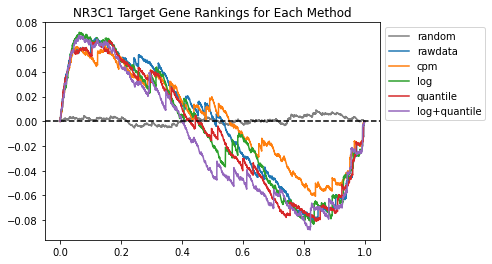

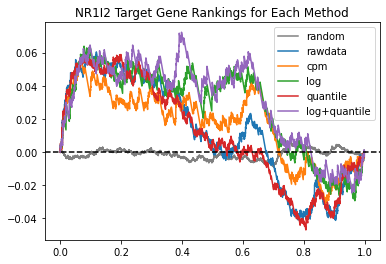

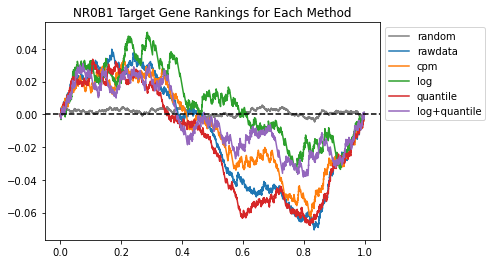

In [77]:
tfBridgePlot()

We can also take the absolute value of the differential expression values before ranking the genes, which allows us to capture genes that are both activated and inhibited towards the earlier ranks. This produces a smoother curve.

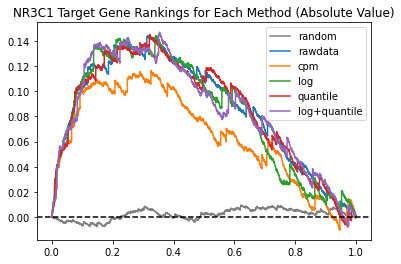

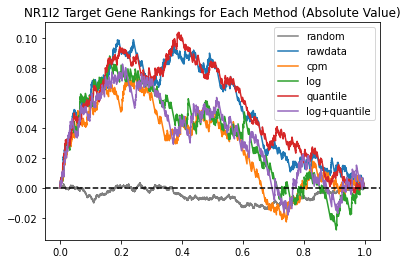

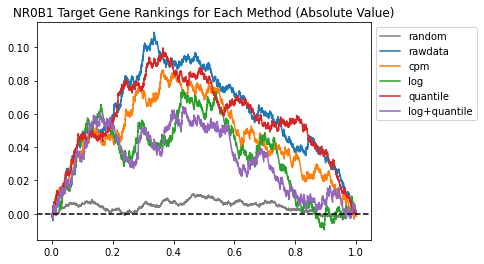

In [78]:
tfBridgePlot(abs_t=True)

In [91]:
def fullBridgePlot(abs_t=False):
    if abs_t:
        tf_res = tf_results_abs
    else: 
        tf_res = tf_results
    for m in methods + ['random']:
        all_x = []
        all_y = []
        for tf in tf_results.keys():
            all_x += tf_res[tf][m]['x']
            all_y += tf_res[tf][m]['y']
        m_x = filledMean(all_x)
        m_y = filledMean(all_y)
        if m == 'random': 
            plt.plot(m_x, m_y, label=m, color='gray')
        elif m == 'cpm': 
            plt.plot(m_x-(0.01*max(m_x)), m_y, label=m)
        else:
            plt.plot(m_x, m_y, label=m)

    plt.axhline(y=0, color='black', linestyle='dashed')
    plt.legend(bbox_to_anchor=(1, 1))
    if abs_t:
        plt.title(f"Average Target Gene Rankings for Each Method (Absolute Value)")
    else:
        plt.title(f"Average Target Gene Rankings for Each Method")
    plt.show()

Finally, we can average the plots across all the transcription factor targets and generate plots using both the original differential expression values and the absolute values.

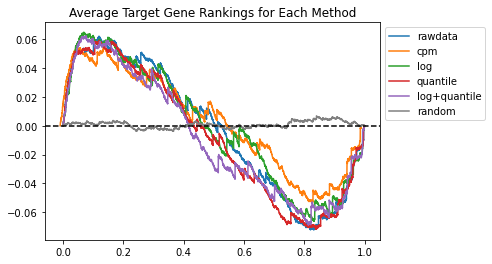

In [92]:
fullBridgePlot()

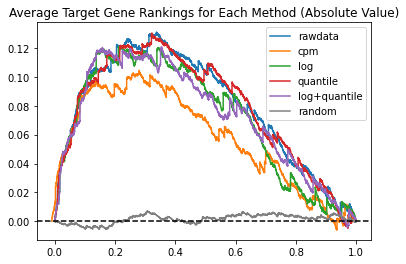

In [93]:
fullBridgePlot(abs_t=True)